# Multiple linear regression


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

## Loading data


In [36]:
df = pd.read_excel("housing_data.xlsx",)

df.head()



,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Extract and split data


In [37]:
# Extract data
cols = df.columns
colsX = [col for col in cols if col != "MEDV"]

X = df[colsX].values
y = df["MEDV"].values


In [38]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [39]:
# Standardization (recommended for Ridge, Lasso and Elastic Net)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

## Model training


In [40]:
def store_results(df, model_name, model, y_train, y_test, y_train_pred, y_test_pred):

    MSE_train = mean_squared_error(y_train, y_train_pred)
    MSE_test = mean_squared_error(y_test, y_test_pred)

    R2_train = r2_score(y_train, y_train_pred)
    R2_test = r2_score(y_test, y_test_pred)

    data = {
        "Model": model_name,
        "Norm of Coef": np.linalg.norm(model.coef_), 
        "Intercept": model.intercept_,
        "MSE Train": [MSE_train],
        "MSE Test": [MSE_test],
        "R2 Train": [R2_train],
        "R2 Test": [R2_test],
    }
    dft = pd.DataFrame(data=data)
    return df.append(dft, ignore_index=True)

def res_plot(ax, y_pred, y, title, color="steelblue"):
    ax.scatter(y_pred, y_pred - y, c=color, marker="o", edgecolor="white", s=70)
    ax.hlines(y=0, xmin=-10, xmax=50, color="black", lw=2)
    ax.axes.set_aspect("equal")
    ax.set_title(title)


def run_model(model, model_name, X_train, y_train, X_test, y_test, df):

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    fig, ax = plt.subplots(
        1, 2, figsize=(9, 5), constrained_layout=True, sharex=True, sharey=True
    )
    res_plot(ax=ax[0], y_pred=y_train_pred, y=y_train, title="Train")
    res_plot(ax=ax[1], y_pred=y_test_pred, y=y_test, title="Test", color="limegreen")
    ax[0].set_xlim([-5, 35])
    fig.supxlabel("Predicted values")
    fig.supylabel("Residual")

    modelIn = model
    if isinstance(model, RANSACRegressor):
        modelIn = model.estimator_ # Need to extract the model out from the wrapper.

    df = store_results(
        df=df,
        model=modelIn,
        model_name=model_name,
        y_train=y_train,
        y_train_pred=y_train_pred,
        y_test=y_test,
        y_test_pred=y_test_pred,
    )

    return df

In [41]:
lr = LinearRegression() 
rc = RANSACRegressor(
        LinearRegression(),
        max_trials=100,
        min_samples=50,
        loss="absolute_loss",
        residual_threshold=10,
        random_state=0,
    )
ridge = Ridge(alpha=20)
lasso = Lasso(alpha=1)
elas = ElasticNet(alpha=1, l1_ratio=0.5)

models=[('Normal', lr), ('RANSAC', rc), ('Ridge', ridge), ('Lasso', lasso), ('elas', elas)]

,Model,Norm of Coef,Intercept,MSE Train,MSE Test,R2 Train,R2 Test
0,Normal,6.947131,22.745480,19.958220,27.195966,0.764545,0.673383
1,RANSAC,6.350747,22.344484,22.749204,33.481761,0.731619,0.597892
2,Ridge,5.936507,22.745480,20.252876,28.129191,0.761069,0.662175
3,Lasso,4.684918,22.745480,26.043216,33.310839,0.692758,0.599944
4,elas,3.702107,22.745480,27.269635,34.884623,0.678289,0.581044


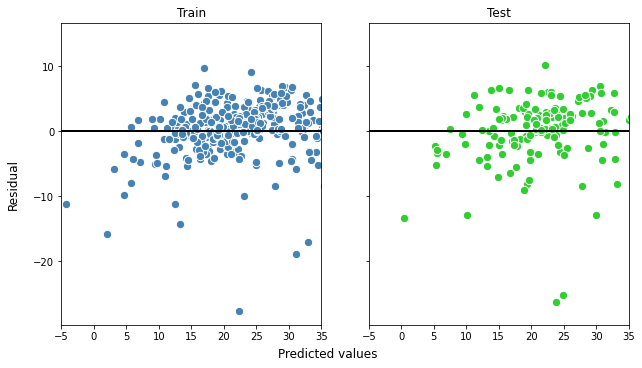

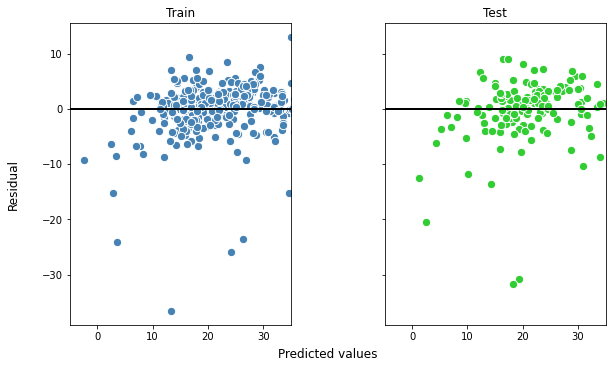

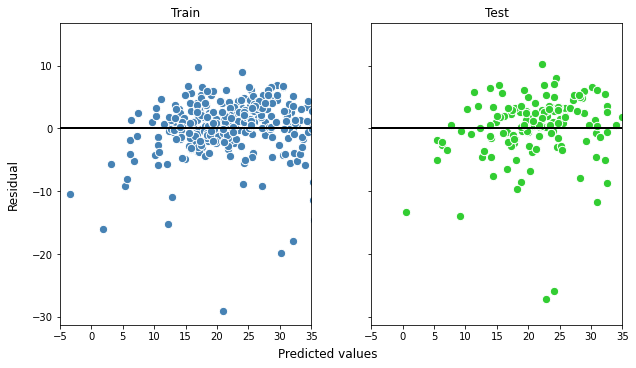

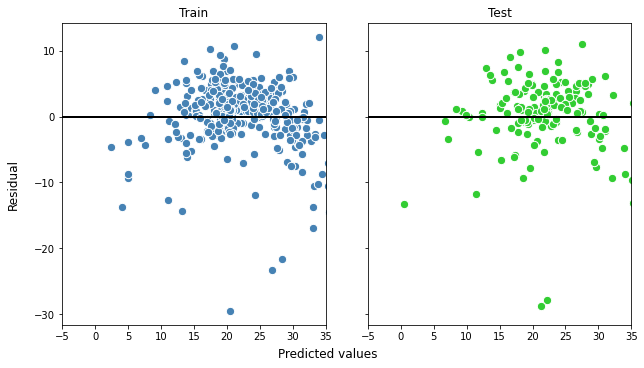

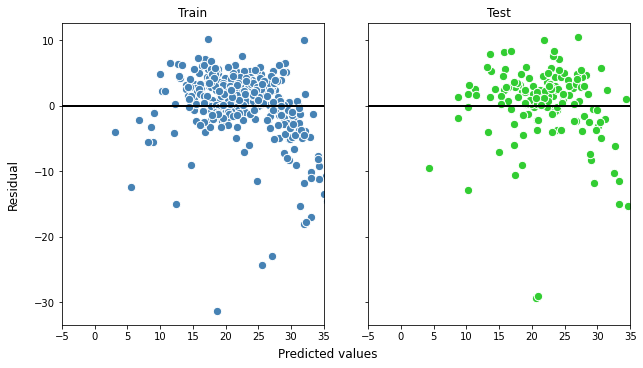

In [42]:
dfAll = pd.DataFrame()

for (name, model) in models:
    dfAll = run_model(
        model=model,
        model_name=name,
        X_train=X_train_std,
        y_train=y_train,
        X_test=X_test_std,
        y_test=y_test,
        df=dfAll,
    )
display(dfAll)